In [ ]:
# 放弃，作为工具暂留，对技术波动的数据不友好

In [2]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import tools.Sample_Tools as smpl

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


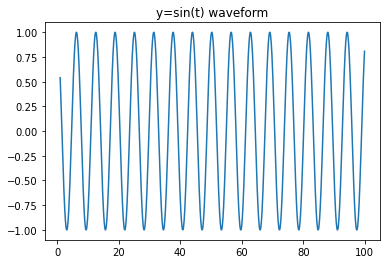

In [147]:
t=np.arange(1,100,0.1)
x=np.cos(t)
plt.title("y=sin(t) waveform")
plt.plot(t,x)
plt.show()

In [3]:
import torch
import torch.nn as nn
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader

torch.manual_seed(1)  # cpu种子

class time_series_dataset(Dataset):
    '''为了后面用DataLoader定义的dataset
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_stacked_layers, output_dim):
        # input_dim  输入的维度
        # hidden_dim 隐藏层特征的维度
        # num_stacked_layers 循环的layers
        # output_dim 输出维度
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # batch_size = x.size(0)
        # h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def lstm_train(data_loader, model_criterion_optimiser=None, 
               input_size=1, hidden_size=4, num_stacked_layers=1 ,output_size=1, learn_rate=0.01,
               historys=None, num_epochs=50, verbose=True):
    '''模型训练
    :param data_loader: {DataLoader}
    :param model_criterion_optimiser: {set} --default：None 
                                            为空时，会重新创建模型/评价器/优化器，
                                            不为空时，沿用外部传送进来的模型，进行持续训练
    :param historys: {list}    --default:None，外部传递进来的list，用于记录loss。
    :param learn_rate: {float} --default:0.01 模型的学习率
    :param num_epochs: {int} --default:50 模型的学习的迭代次数
    :return: {set} --返回（模型,评价器,优化器）
    '''
    
    if model_criterion_optimiser is None:
        model = LSTM(input_dim=input_size, hidden_dim=hidden_size, num_stacked_layers=num_stacked_layers,output_dim=output_size)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.Adam(model.parameters(), lr=learn_rate)
    else:
        model = model_criterion_optimiser[0]
        criterion = model_criterion_optimiser[1]
        optimiser = model_criterion_optimiser[2]
    
    start_time = time.time()
    model.train(True)
    for t in range(num_epochs):
        running_loss = .0
        for batch_index, batch in enumerate(data_loader):
            x_batch,y_batch = batch[0],batch[1]

            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if verbose:
                if batch_index == x_batch.shape[0]-1:
                    print("Batch index:{0} avgLoss: {1}".format(batch_index+1,running_loss/x_batch.shape[0]))
        if not historys is None:
            historys.append(running_loss)
        if verbose:
            if t%10==0:
                print("Epoch ", t, "MSE: ", running_loss)

    training_time = time.time() - start_time
    print("Training time: {}".format(training_time))
    return model,criterion,optimiser


def model_check_plot(model,criterion, x, y, historys=None):
    '''显示预测结果的图标
    :param model: {nn.Module} --LSTM模型本身
    :param criterion: {torch.nn.MSELoss()} --评价器 
    :param x: {[batch_size[sequence_size[input_size]]]}
    :param y: {[[input_size]]}
    :param historys: {list}    --default:None，非空时，绘制学习曲线
    :return: None
    '''
    model.train(False)
    with torch.no_grad():
        predict = model(x)
        loss = criterion(predict, y)
        running_loss = loss.item()
    print("validate loss: {:.5f} ,avg loss: {:.8f}".format(loss.item(),loss.item()/len(x)))
    
    predict = pd.DataFrame(predict.numpy().squeeze())
    original = pd.DataFrame(y.numpy().squeeze())
    print(len(predict),len(original))

    fig = plt.figure(figsize=(1620/72,420/72))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax = plt.plot(list(original.index), original.values, label="Data", color='royalblue')
    ax = plt.plot(list(predict.index), predict.values, label="Training Prediction (LSTM)", color='tomato')
    if not historys is None:
        ax3 = plt.gca().twinx()
        ax3 = plt.gca().twiny()
        ax3.plot(historys,linestyle=":", linewidth=1,color="black",label='bm')
    plt.show()
   


In [4]:
def preprocess(data_values, lookback, batch_size, train_suffle=False, scaler=None, test_size=.1, verbose=False, return_base=True):
    '''预处理数据
    :param data_values: {np.array} --数据序列
    :param lookback: {int} --数据的回望长度,相当于sequence_size 
    :param batch_size: {int} --批处理大小
    :param train_suffle: {BOOL} --是否乱序训练数据
    :param test_size: {float} --default:.1，测试数据占比，默认10%作为测试。
    :param scaler: {sklearn.preprocessing.MinMaxScaler} --default:None，为空时不归一数据
    :param return_base: {BOOL} --default:False，影响返回的内容
                                 False：返回 （训练数据loader ， 测试数据loader）
                                 True：返回 （x_train, x_test, y_train, y_test, train_loader, test_loader）
    :return: {SET} 详细见参数return_base
    '''
    data_tmp = []
    for i in range(len(data_values)-lookback) :
        data_tmp.append(data_values[i:i+lookback+1])
    data_tmp = np.array(data_tmp)

    if not scaler is None:
        # scaler=MinMaxScaler(feature_range=(0,1))
        data_tmp=scaler.fit_transform(data_tmp) 
        # scaler.inverse_transform(data_tmp)
        
    x = data_tmp[:,:-1].reshape(-1,lookback,1)
    x = torch.tensor(x).to(torch.float32)
    y = data_tmp[:,-1].reshape(-1,1)
    y = torch.tensor(y).to(torch.float32)
    x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=.1, shuffle=False)

    if verbose:
        print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

    train_dataset = time_series_dataset(x_train, y_train)
    test_dataset = time_series_dataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=train_suffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if return_base:
        return x_train,x_test, y_train, y_test, train_loader, test_loader
    else:
        return train_loader, test_loader



In [ ]:
c = data_.loc[(slice(None),['000001','000002','601919','002415']),]
c_ret = smpl.get_current_return(c,'close').dropna()
# c_ret_x = c_ret.shift(1).dropna().values
# c_ret_y = c_ret[1:].values
# c_ret_x = c_ret.shift(1).dropna().values.reshape(-1,1)
# c_ret_y = c_ret[1:].values.reshape(-1,1)

scalers=[] #保留缩放器
processeds=[] #数据按code分别处理，用于保持结果。
for code in c_ret.index.get_level_values('code').unique():
    # d=c.loc[(slice(None),code),'close'].values
    d=c_ret.loc[(slice(None),code)].values
    # scaler=MinMaxScaler(feature_range=(0,1))
    scaler=None
    # scalers.append(scaler)
    res = preprocess(d, lookback=22, batch_size=10, train_suffle=True, scaler=scaler, verbose=True, return_base=True)
    processeds.append(res)
    

In [ ]:
model_criterion_optimiser = None
# 根据不同code对应的loader，来训练模型。
for data in processeds:
    train_loader=data[4]
    model_criterion_optimiser = lstm_train(train_loader, input_size=1, hidden_size=8, num_stacked_layers=1,
                                   model_criterion_optimiser=model_criterion_optimiser,
                                   output_size=1, num_epochs=50,historys=None,verbose=False)


In [ ]:
model_check_plot(model_criterion_optimiser[0], model_criterion_optimiser[1], processeds[1][0], processeds[1][2])


In [ ]:
model_check_plot(model_criterion_optimiser[0], model_criterion_optimiser[1], processeds[2][0][40:80], processeds[2][2][40:80])


In [3]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2019'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [21]:
t=np.arange(1,100,0.1)
x=np.sin(t)

x = data_.close.loc[(slice(None),'000001'),]

scaler=MinMaxScaler(feature_range=(0,1))
x_train,x_test, y_train, y_test, train_loader, test_loader = preprocess(x, 33, 10, train_suffle=True, scaler=scaler, test_size=.01, verbose=False, return_base=True)
model_criterion_optimiser = lstm_train(train_loader, input_size=1, hidden_size=90, num_stacked_layers=15,
                                   model_criterion_optimiser=None,
                                   output_size=1, num_epochs=50,historys=None,verbose=True)

Batch index:10 avgLoss: 0.3343097951263189
Epoch  0 MSE:  6.199866523966193
Batch index:10 avgLoss: 0.0318941299803555
Batch index:10 avgLoss: 0.03207690678536892
Batch index:10 avgLoss: 0.03204569555819035
Batch index:10 avgLoss: 0.032373028621077535
Batch index:10 avgLoss: 0.033613001089543106
Batch index:10 avgLoss: 0.043370011076331136
Batch index:10 avgLoss: 0.04070368446409702
Batch index:10 avgLoss: 0.04193891985341906
Batch index:10 avgLoss: 0.04297956209629774
Batch index:10 avgLoss: 0.030876789800822736
Epoch  10 MSE:  3.0003424286842346
Batch index:10 avgLoss: 0.03944493178278208
Batch index:10 avgLoss: 0.033570818789303306
Batch index:10 avgLoss: 0.03599164001643658
Batch index:10 avgLoss: 0.036350798420608045
Batch index:10 avgLoss: 0.032949271891266105
Batch index:10 avgLoss: 0.03540260279551148
Batch index:10 avgLoss: 0.04421434737741947
Batch index:10 avgLoss: 0.031054364889860152
Batch index:10 avgLoss: 0.03829243797808886
Batch index:10 avgLoss: 0.036246847920119764
E

validate loss: 0.03441 ,avg loss: 0.00004062
847 847


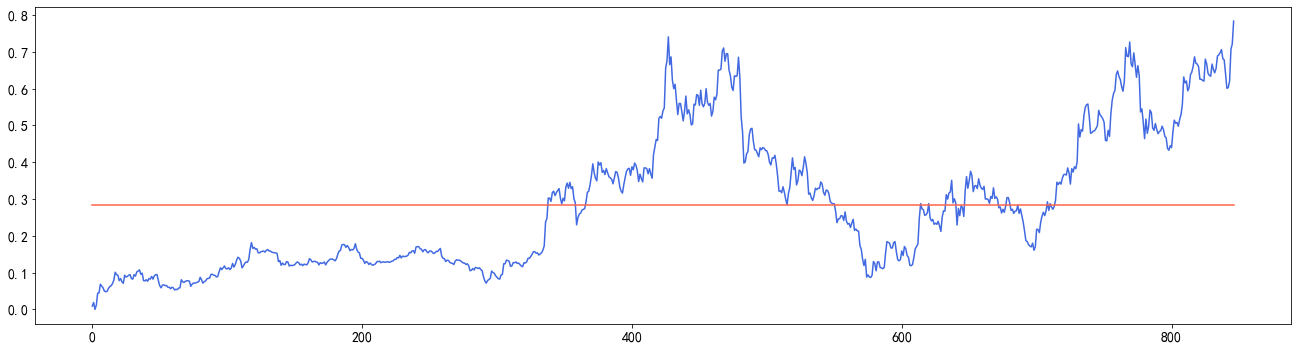

validate loss: 0.02042 ,avg loss: 0.00040833
50 50


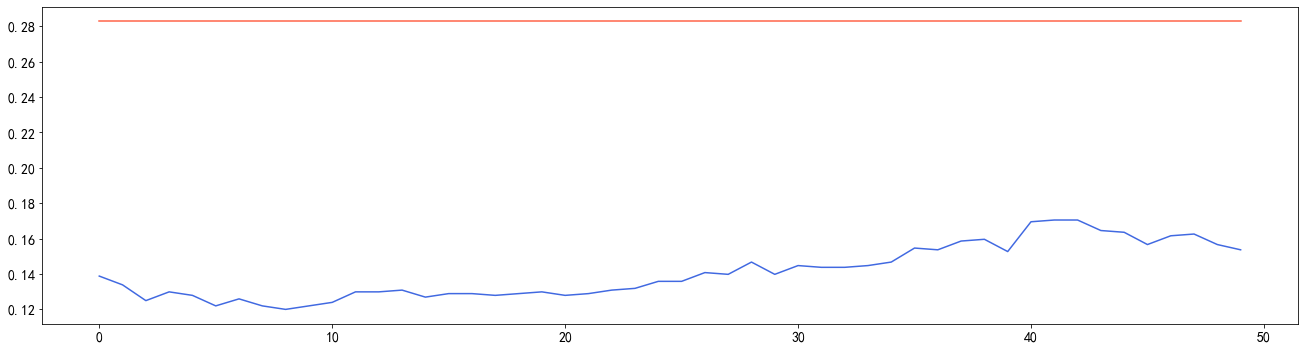

In [22]:
model_check_plot(model_criterion_optimiser[0], model_criterion_optimiser[1], x_train, y_train)
model_check_plot(model_criterion_optimiser[0], model_criterion_optimiser[1], x_train[200:250], y_train[200:250])

In [12]:
data_.iloc[0:20][['volume','amount']]

volume        amount
date       code                          
2016-01-04 000001  563497.0  6.603761e+08
           000004   22833.0  9.767486e+07
           000006  232852.0  2.546398e+08
           000008  140399.0  1.570146e+08
           000009  672531.0  1.130235e+09
           000010  145419.0  1.386721e+08
           000011   59154.0  8.080618e+07
           000012  515143.0  6.451437e+08
           000014   45083.0  9.585238e+07
           000016  444168.0  2.887201e+08
           000017   81841.0  1.066830e+08
           000019   67573.0  1.087950e+08
           000020   73819.0  2.173251e+08
           000021  198711.0  2.264005e+08
           000025   59429.0  4.673416e+08
           000026   71301.0  1.096078e+08
           000027  224952.0  2.103237e+08
           000029  106835.0  1.297588e+08
           000030  128526.0  1.244531e+08
           000031  291169.0  3.911475e+08